In [1]:
from datasets import load_dataset,DatasetDict
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import io
import os
from PIL import Image
import random
import torchvision.transforms as transforms
import utils
import torch.nn as nn
import torch
from torch.utils.tensorboard import SummaryWriter
import numpy as np
from tqdm import tqdm
import time

/home/omar/TUM/05_projects/Image_generation_with_VAE/vae_venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Download and split the dataset into train,test and validation sets. 

In [2]:
ds = load_dataset("Karthik11232/human_face_generation")
#split the dataset 
train_test_set = ds['train'].train_test_split(test_size=0.2)
#print(train_test_set)
train_val_set = train_test_set['train'].train_test_split(test_size=0.2)

ds = DatasetDict({
    'train': train_test_set['train'],
    'test': train_test_set['test'],
    'validation': train_val_set['test']
})
#print (ds)
print(ds.shape)
print(train_test_set.shape)
print(train_val_set.shape)

{'train': (2132, 1), 'test': (533, 1), 'validation': (427, 1)}
{'train': (2132, 1), 'test': (533, 1)}
{'train': (1705, 1), 'test': (427, 1)}


Save the datasets to disk

In [3]:
# Save the datasets to disk
output_dir = './human_face_generation_split/raw'
if not os.path.exists(output_dir):  
    os.makedirs(output_dir, exist_ok=True)
# Save each split to disk
    utils.save_images(ds['train'], 'train',output_dir)
    utils.save_images(ds['validation'], 'validation')
    utils.save_images(ds['test'], 'test')

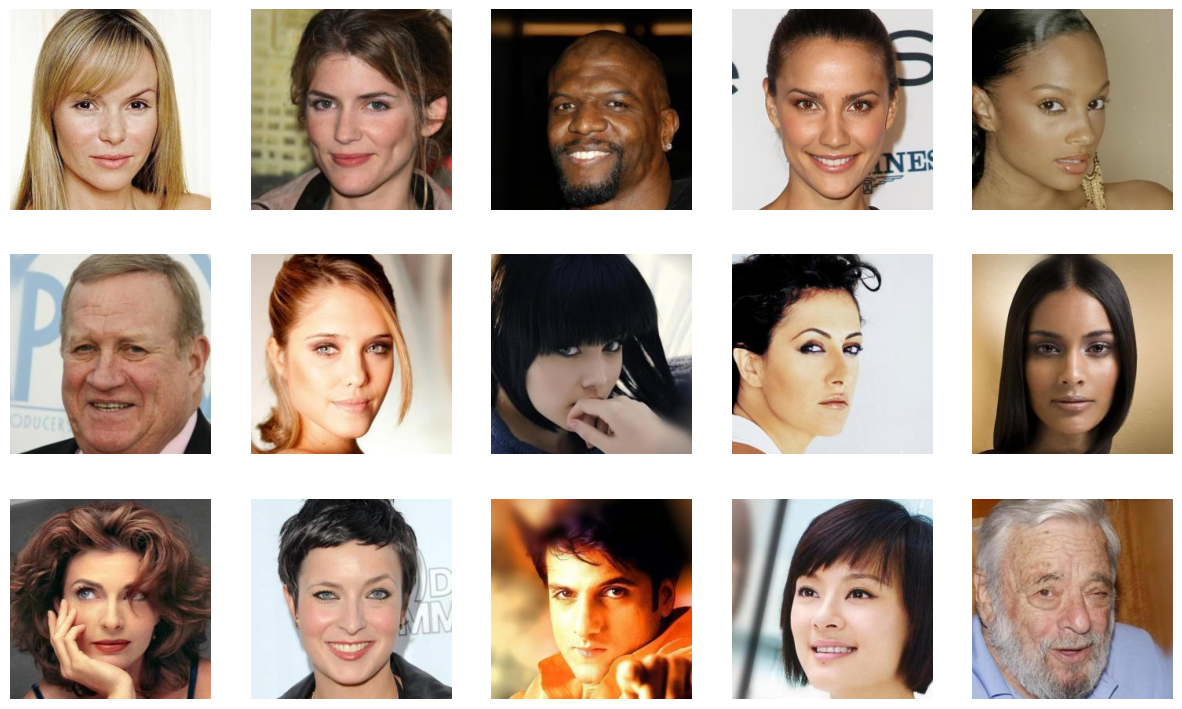

In [4]:
# Plot 15 random images in 3 rows and 5 columns
utils.plot_random_images(dataset_path='human_face_generation_split/raw/train', num_images=15, rows=3, cols=5)

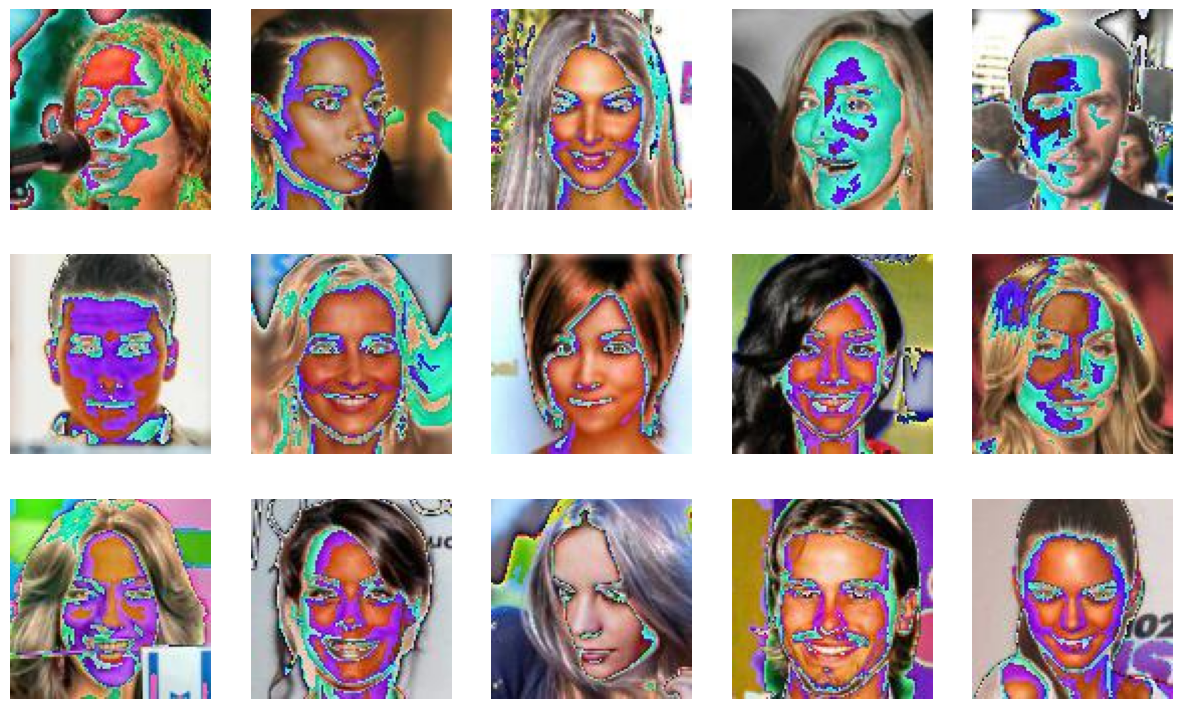

(100, 100)


In [54]:
# Prepoccessing 
preprocess = transforms.Compose([
    transforms.Resize((100, 100)),  # Resize to a specific size if needed tried 200x200 was too big
    transforms.ToTensor(),          # Convert to tensor and normalize
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])
preprocessed_output_dir = './human_face_generation_split/preprocessed'
os.makedirs(preprocessed_output_dir, exist_ok=True)
if True:#not os.path.exists(preprocessed_output_dir):
# Save preprocessed training images

    utils.save_images(ds['train'], 'train', preprocessed_output_dir,preprocess=preprocess)
    utils.plot_random_images(os.path.join(preprocessed_output_dir, 'train'), num_images=15, rows=3, cols=5)
    img = Image.open("human_face_generation_split/preprocessed/train/image_2110.png")
    print(img.size)


In [86]:
# first implement a simple Autoencoder with Linear layers
class Autoencoder_linear(nn.Module):
    def __init__(self):
        super().__init__()
        self.size_hidden_layers = 1024 
        self.encoder = nn.Sequential(
            nn.Linear(10000,5000),
            nn.ReLU(),
            nn.Linear(5000,2000),
            nn.ReLU(),
            nn.Linear(2000,self.size_hidden_layers),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(self.size_hidden_layers,2000),
            nn.ReLU(),
            nn.Linear(2000,5000),
            nn.ReLU(),
            nn.Linear(5000,10000),
            nn.ReLU(),
        )
    def init_weights(m):
        if isinstance(m, nn.Linear):
            torch.nn.init.xavier_uniform(m.weight)
            m.bias.data.fill_(0.01)
   # init_weights(self.encoder)
    def forward(self,x):
        encoded=self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded,decoded

In [87]:
class ImageDataset(torch.utils.data.Dataset):
    def __init__(self,image_folder):
        self.image_folder=image_folder
        self.images = os.listdir (image_folder)
        self.transform = transforms.Compose([
            transforms.Resize((100, 100)),  # Resize images to 200x200
            transforms.ToTensor()           # Convert images to PyTorch tensors
        ])
    def __getitem__(self,idx):
        image_file = self.images[idx]
        image = Image.open((self.image_folder +"/"+ image_file))
        image = self.transform(image)
        image = np.array(image).reshape(-1,100*100) #for lin autoencoder
        image = torch.Tensor(image)
        return image
    def __len__(self):
        return len(self.images)
    
dataset_preprocessed = ImageDataset("human_face_generation_split/preprocessed/train")
dataset_val = ImageDataset("human_face_generation_split/raw/validation")
dataset_test = ImageDataset("human_face_generation_split/raw/test")
show_dataset = ImageDataset("human_face_generation_split/show_imgs/train")

train_data = torch.utils.data.DataLoader(dataset_preprocessed,batch_size=32,shuffle=True)
val_data = torch.utils.data.DataLoader(dataset_val)
test_data = torch.utils.data.DataLoader(dataset_test)
show_data =torch.utils.data.DataLoader(show_dataset)

In [88]:
#ckp_path="human_face_generation_split_data{}.ckp"
crt_time = time.strftime("%Y%m%d_%H%M%S")
dir_ckpt = os.path.join("human_face_generation_split/",str(crt_time))
os.mkdir(dir_ckpt)
writer = SummaryWriter()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
linear_auto = Autoencoder_linear()
print(linear_auto)
linear_auto.to(device)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(linear_auto.parameters(), lr=1e-4)
#scheduler = StepLR(optimizer, step_size=30, gamma=0.1)

epochs =  101
#training
# Training
for epoch in range(epochs):
    total_loss = 0
    with tqdm(train_data, unit="batch", total=len(train_data), desc=f"Epoch {epoch+1}/{epochs}") as tepoch:
        for batch_idx, data in enumerate(tepoch):
            data = data.to(device)
            #print(data.shape)
            encoded, decoded = linear_auto(data)
            loss = loss_function(decoded, data)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * data.size(0)
            
            # Set the postfix with current loss
            tepoch.set_postfix(loss=total_loss / ((batch_idx + 1) * data.size(0)))
            writer.add_scalar("Loss/train", loss, epoch)

            #print(decoded.shape)

        if epoch % 20== 0:
            linear_auto.eval()  # Set the model to evaluation mode
            ckpt_file = os.path.join(dir_ckpt, f"checkpoint_epoch_{epoch+1}.pt")
    
            torch.save({
                'epoch': epoch,
                'state_dict': linear_auto.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': total_loss,
                
            },ckpt_file)
epoch_loss = total_loss / len(train_data.dataset)
print(f"Epoch {epoch+1}/{epochs} : loss = {epoch_loss:.4f}")

cuda:0
Autoencoder_linear(
  (encoder): Sequential(
    (0): Linear(in_features=10000, out_features=5000, bias=True)
    (1): ReLU()
    (2): Linear(in_features=5000, out_features=2000, bias=True)
    (3): ReLU()
    (4): Linear(in_features=2000, out_features=1024, bias=True)
    (5): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=1024, out_features=2000, bias=True)
    (1): ReLU()
    (2): Linear(in_features=2000, out_features=5000, bias=True)
    (3): ReLU()
    (4): Linear(in_features=5000, out_features=10000, bias=True)
    (5): ReLU()
  )
)


Epoch 21/101: 100%|██████████| 67/67 [00:12<00:00,  5.24batch/s, loss=0.0508]


In [84]:
#import gc
#
#linear_auto.cpu()
#del linear_auto
#gc.collect()
#torch.cuda.empty_cache()

In [85]:
linear_auto = Autoencoder_linear()
checkpoint = torch.load("human_face_generation_split/20240901_165522/checkpoint_epoch_101.pt", weights_only=True)
linear_auto.load_state_dict(checkpoint['state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']
linear_auto.eval()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
def plot_original_and_reconstructed(model, dataloader, num_images=5):
    model.eval()  # Set the model to evaluation mode
    
    images = []
    reconstructed_images = []
    
    with torch.no_grad():
        for idx, data in enumerate(dataloader):
            data = data.to(device)  # Move data to the same device as the model
            _, reconstructed = model(data)
            
            # Move tensors back to CPU for visualization
            data = data.cpu().numpy()
            reconstructed = reconstructed.cpu().numpy()
            print(f"Original shape: {data.shape}, Reconstructed shape: {reconstructed.shape}")  # Debugging output

            images.extend(data[:num_images])  # Original images
            reconstructed_images.extend(reconstructed[:num_images])  # Reconstructed images
            
            if len(images) >= num_images:
                break

    # Plot the original and reconstructed images side by side
    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        # Original images
        plt.subplot(2, num_images, i + 1)
        plt.imshow(images[i].reshape(3, 100, 100).transpose(1, 2, 0))  # Reshape and transpose for RGB
        plt.title("Original")
        plt.axis('off')
        
        # Reconstructed images
        plt.subplot(2, num_images, num_images + i + 1)
        plt.imshow(reconstructed_images[i].reshape(3, 100, 100).transpose(1, 2, 0))  # Reshape and transpose for RGB
        plt.title("Reconstructed")
        plt.axis('off')
    
    plt.show()

# Assuming you want to plot 5 images
plot_original_and_reconstructed(linear_auto, show_data, num_images=5)


cuda:0


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)

In [ ]:
class Autoencoder_conv(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels = 3 , out_channels = 32, kernel_size = 2 ,stride = 2),
            nn.ReLU(),# possibly add max pooling
            nn.Conv2d(in_channels = 32,out_channels = 64, kernel_size = 2, stride = 2),
            nn.ReLU()
        )    
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels = 64,out_channels=32,kernel_size=2,stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels = 32 , out_channels = 3 ,kernel_size=2,stride =2),
            nn.ReLU()
        )
    def forward(self,x):
            encoded = self.encoder(x)
            decoded = self.decoder(encoded)
            return encoded, decoded

In [ ]:

writer = SummaryWriter()

crt_time = time.strftime("%Y%m%d_%H%M%S")
dir_ckpt = os.path.join("human_face_generation_split/",str(crt_time)+"conv")
os.mkdir(dir_ckpt)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
autoencoder_conv = Autoencoder_conv().to(device)  # Move the model to GPU
print(autoencoder_conv)
#linear_auto = Autoencoder_linear()

loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder_conv.parameters(), lr=1e-4)
#scheduler = StepLR(optimizer, step_size=30, gamma=0.1)

epochs =  100
#training
# Training
for epoch in range(epochs):
    total_loss = 0
    with tqdm(train_data, unit="batch", total=len(train_data), desc=f"Epoch {epoch+1}/{epochs}") as tepoch:
        for batch_idx, data in enumerate(tepoch):
            #print(data.shape)  # Add this to debug the shape

            data = data.to(device)
            encoded, decoded = autoencoder_conv(data)
            loss = loss_function(decoded, data)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * data.size(0)
            
            # Set the postfix with current loss
            tepoch.set_postfix(loss=total_loss / ((batch_idx + 1) * data.size(0)))
            writer.add_scalar("Loss/train", loss, epoch)

            #print(decoded.shape)

    if (epoch+1) % 10 == 0:
        autoencoder_conv.eval()  # Set the model to evaluation mode
        ckpt_file = os.path.join(dir_ckpt, f"checkpoint_epoch_{epoch+1}.pt")

        torch.save({
            'epoch': epoch,
            'state_dict': autoencoder_conv.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': total_loss,
            
        },ckpt_file)
    epoch_loss = total_loss / len(train_data.dataset)
    print(f"Epoch {epoch+1}/{epochs} : loss = {epoch_loss:.4f}")
writer.close()

In [ ]:
# VAE
class VAE:
    def __init__(self):
        super().__init__()
    
    def encoder(self, data):
        # Define the encoder architecture
        # The output shape should be (batch_size, latent_dim, 4, 4)
        pass
    def decoder(self, data):
        # Define the decoder architecture
        # The output shape should be (batch_size, 3, 200, 200)
        pass
    def reparametrize(self, data):
        # Implement reparameterization trick to sample z from the latent space
        pass
    def forward(self, data):
        # Implement the forward pass through the VAE
        # Return the reconstructed data, the latent mean, and the latent log variance
        pass
